In [5]:
import os
os.chdir('/Users/sukhmac/Programming/FunCoding/Research/RLProgramming/GittenBandit')  # Set the correct path to your project root

In [6]:
import numpy as np
from Environment.test_cases import test1
from Environment.mab_environment import Mab
from Strategies.strategy_interface import StrategyInterface
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
class Reinforce(StrategyInterface):
    def __init__(self, 
                 num_arms, 
                 num_states_per_arm,
                 homogeneous,
                 discount_factor, 
                 episode_len, 
                 learning_rate, 
                 temperature,
                 schedule=None):
        super().__init__("Reinforce")
        self.k = num_arms
        self.n = num_states_per_arm
        self.discount_factor = discount_factor
        self.episode_len = episode_len
        self.learning_rate = learning_rate
        
        self.schedule = schedule
        if self.schedule is None:
            self.t = temperature
        elif self.schedule == "linear":
            self.max_temp = temperature  # Boltzmann temperature
            self.min_temp = 0.5  # based on Barto et al 1991 (Appendix B)
            self.t = self.max_temp  # cur_temp
            self.beta = 0.992  # used to update cur_temp
            
        self.homogeneous = homogeneous
        if self.homogeneous:
            self.h = np.zeros((self.n))  # preference for each state
        else:
            self.h = np.zeros((self.k, self.n))  # preference for each (k, n), i.e. kth arm and nth state

    def get_action(self, cur_state):
        '''
        Using Boltzmann Sampling
        cur_states : np.array((self.k)) : state of each arm
        '''
        action_probability = np.zeros((self.k))  # probability of selecting each arm
        
        if self.homogeneous:
            total = sum([np.exp(self.h[cur_state[i]]/self.t) for i in range(self.k)])
            for i in range(self.k):
                action_probability[i] = np.exp(self.h[cur_state[i]]/self.t) / total
        else:
            total = sum([np.exp(self.h[i][cur_state[i]]/self.t) for i in range(self.k)])
            for i in range(self.k):
                action_probability[i] = np.exp(self.h[i][cur_state[i]]/self.t) / total

        action = int(np.random.choice(range(self.k), p=action_probability))

        return action, action_probability

    def update(self, 
               cur_state,
               action_taken,
               action_probability,
               reward, 
               cumm_reward,
               cur_time):
        
        if self.homogeneous:
            for i in range(self.k):
                if i == action_taken:
                    self.h[cur_state[i]] += (self.learning_rate 
                                             * self.discount_factor**cur_time
                                             * cumm_reward 
                                             * 1/self.t
                                             * (1 - action_probability[i]))
                else:
                    self.h[cur_state[i]] += (self.learning_rate 
                                             * self.discount_factor**cur_time
                                             * cumm_reward
                                             * 1/self.t
                                             * - action_probability[i])
        else:
            for i in range(self.k):
                if i == action_taken:
                    self.h[i][cur_state[i]] += (self.learning_rate 
                                                * self.discount_factor**cur_time
                                                * cumm_reward 
                                                * 1/self.t
                                                * (1 - action_probability[i]))
                else:
                    self.h[i][cur_state[i]] += + (self.learning_rate 
                                                  * self.discount_factor**cur_time
                                                  * cumm_reward 
                                                  * 1/self.t
                                                  * - action_probability[i])

        # decrease the temp if schedule is not None
        if self.schedule == "linear":
            self.t = self.min_temp + self.beta * (self.t - self.min_temp)
            
        return

    def reset(self):
        if self.homogeneous:
            self.h = np.zeros((self.n))  # preference for each state
        else:
            self.h = np.zeros((self.k, self.n))  # preference for each (k, n), i.e. kth arm and nth state
            
        if self.schedule == "linear":
            self.t = self.max_temp

    def visualize_h_average(self, h_average, homogeneous, title, savepath):
        if not homogeneous:
            # Plot all k x n variables on the same figure
            for i in range(self.k):
                for j in range(self.n):
                    plt.plot(h_average[:, i, j], label=f'h[{i}][{j}]')
                    plt.text(h_average.shape[0]-1, h_average[:, i, j][-1], f'({i},{j})', 
                             fontsize=8, verticalalignment='bottom', horizontalalignment='left')
            plt.legend()
            plt.xlabel("episode")
            plt.ylabel("preference")
            plt.title(title)
            plt.savefig(savepath)
            plt.show()

In [20]:
def calculate_regret(mab, strategy, episode_len, optimal_reward, discount_factor):
    cumm_reward = 0
    # generate episode
    mab.reset(random=True)
    for t in range(episode_len):
        cur_state = mab.get_cur_state()
        action, action_probability = strategy.get_action(cur_state)
        _, reward = mab.step(action)
        cumm_reward += (discount_factor**t) * reward

    regret = cumm_reward - optimal_reward
    return regret

def calculate_optimal_reward(test, mab, episode_len):
    num_runs = 100
    optimal_reward = np.zeros((num_runs))
    for run in range(num_runs):    
        mab.reset(random=True)
        for t in range(episode_len):
            cur_state = mab.get_cur_state()
            action = test.get_highest_rank(cur_state)
            _, reward = mab.step(action)
            optimal_reward[run] += (test.discount_factor**t) * reward

    return np.mean(optimal_reward, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08#runs/s]


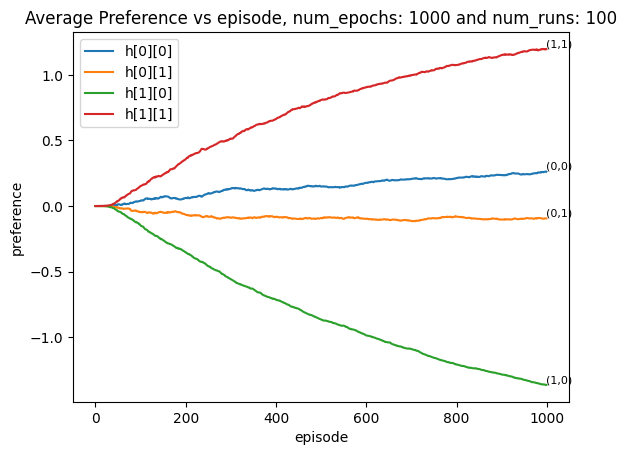

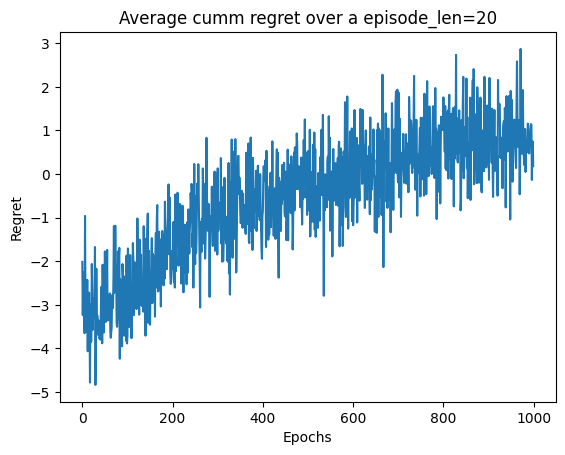

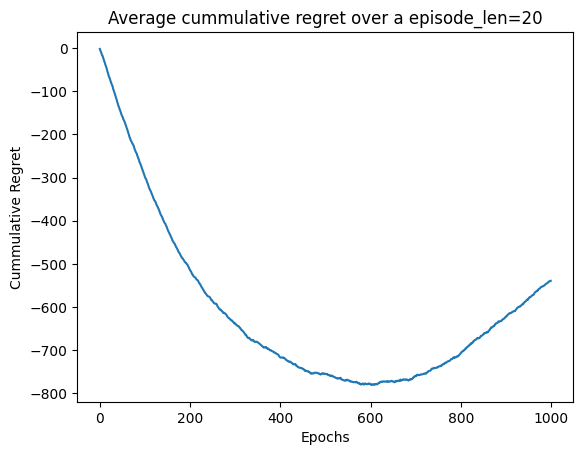

In [22]:
num_epochs = 1000
episode_len = 20
num_runs = 100
learning_rate = 0.001
temperature = 200
test = test1
test_string = "test1"
optimal_reward = calculate_optimal_reward(test, mab, episode_len)

mab = Mab(num_arms = test.num_arms,
          num_states_per_arm = test.num_states_per_arm,
          transition_matrices = test.transition_matrices,
          reward_matrices = test.reward_matrices,
          initial_start_state = test.initial_start_state,
          homogeneous = test.homogeneous)

reinforce = Reinforce(num_arms = test.num_arms,
                      num_states_per_arm = test.num_states_per_arm,
                      homogeneous=test.homogeneous,
                      discount_factor = test.discount_factor,
                      episode_len = episode_len, 
                      learning_rate = learning_rate,
                      temperature = temperature,
                      schedule="linear")

# Code for non-homogeneous
h_history = np.zeros((num_runs, num_epochs, mab.k, mab.n))
regret_history = np.zeros((num_runs, num_epochs))
cumm_regret = np.zeros((num_epochs))

for run in tqdm(range(num_runs), unit="#runs"):
    reinforce.reset()
    for epoch in range(num_epochs):
        mab.reset(random=True)
        state_history = np.zeros((episode_len, mab.k), dtype=int)
        action_history = np.zeros((episode_len), dtype=int)
        action_probability_history = np.zeros((episode_len, mab.k))
        reward_history = np.zeros((episode_len))
        
        # generate episode
        for t in range(episode_len):
            cur_state = mab.get_cur_state()
            action, action_probability = reinforce.get_action(cur_state)
            _, reward = mab.step(action)
            
            state_history[t] = cur_state.copy()
            action_history[t] = action
            action_probability_history[t] = action_probability.copy()
            reward_history[t] = reward

        # Compute cumulative reward G_t for each time step
        G = 0
        return_history = np.zeros((episode_len))  # = \sum_t^T R_t
        for t, reward in enumerate(reversed(reward_history)):
            G = reward + test.discount_factor * G
            return_history[episode_len - t - 1] = G
    
        # update reinforce
        for t in range(episode_len):
            reinforce.update(cur_state=state_history[t],
                             action_taken=action_history[t],
                             action_probability=action_probability_history[t],
                             reward=reward_history[t], 
                             cumm_reward=return_history[t],
                             cur_time=t)

        # update h_history
        h_history[run, epoch] = reinforce.h.copy()

        # calculate regret
        regret_history[run][epoch] = calculate_regret(mab, reinforce, episode_len, optimal_reward, test.discount_factor)

regret_history_average = np.mean(regret_history, axis=0)  # shape: (num_episodes)
h_average = np.mean(h_history, axis=0)  # shape: (num_episode, k, n)
reinforce.visualize_h_average(h_average,
                              homogeneous=test.homogeneous,
                              title=f"Average Preference vs episode, num_epochs: {num_epochs} and num_runs: {num_runs}",
                              savepath=f"Results/Reinforce/{test_string}_num_epochs={num_epochs}_num_runs={num_runs}_lr={learning_rate}_episode_len={episode_len}.png")

plt.plot(regret_history_average)
plt.xlabel("Epochs")
plt.ylabel("Regret")
plt.title(f"Average cumm regret over a episode_len={episode_len}")
plt.show()

cumm_regret_counter = 0
for epoch in range(num_epochs):
    cumm_regret_counter += regret_history_average[epoch]
    cumm_regret[epoch] = cumm_regret_counter

plt.plot(cumm_regret)
plt.xlabel("Epochs")
plt.ylabel("Cummulative Regret")
plt.title(f"Average cummulative regret over a episode_len={episode_len}")
plt.show()